In [1]:
import pandas as pd
import numpy as np
import pickle
import re
import nltk
import string
import emoji
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline


In [2]:
FINE_TUNED_DIR = '../../pretained_or_finetune-models'
REVIEWS_DATASET_DIR = '../../dataset'
UTILS_DIR = '../../utils'
NLTK_DATA_PATH = f"{FINE_TUNED_DIR}/nltk_data"

nltk.data.path.append(NLTK_DATA_PATH)

In [3]:
tourism_reviews_en = pd.read_csv(f"{REVIEWS_DATASET_DIR}/eng_reviews_emotion_classify.csv", encoding='utf-8')

columns_to_use = ['helpful_votes', 'location_id', 'review_id', 'review',
                  'review_subject', 'trip_type', 'rating',
                  'location_name', 'province', 'place_id', 'emotion', 'cleaned_review']
columns_to_train = ['location_id', 'review', 'rating']
review_df = tourism_reviews_en[columns_to_train]

In [4]:
review_df.describe()

,location_id,rating
count,5.909000e+03,5909.000000
mean,6.483167e+06,4.153833
std,4.877561e+06,1.067077
min,3.110380e+05,1.000000
25%,2.578107e+06,4.000000
50%,6.017599e+06,4.000000
75%,8.818088e+06,5.000000
max,2.714283e+07,5.000000


In [5]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5909 entries, 0 to 5908
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   location_id  5909 non-null   int64 
 1   review       5909 non-null   object
 2   rating       5909 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 138.6+ KB


In [6]:
review_df

,location_id,review,rating
0,2209612,Besides elegant grand palace and wat pra kaew ...,5
1,2209612,This is one of the last big king temples of Ba...,4
2,2209612,"It is beautiful, clean and free to enter. Both...",4
3,2209612,Wat Ratchabophit is a Buddhist temple located ...,5
4,2209612,Wat Ratchabophit is a historic royal temple bu...,5
...,...,...,...
5904,1831068,Is quite far from Korat Town or main highway. ...,3
5905,1831068,Prasat Pueai Noi is claimed to be the biggest ...,3
5906,1831068,I think this place is claimed to be the oldest...,4
5907,1831068,The compound comprises three brick buildings o...,4


In [7]:
from nltk.corpus import stopwords

custom_stopwords = set(stopwords.words('english')) 

In [8]:
from nltk.stem import WordNetLemmatizer

stop_words = custom_stopwords
lemmatizer = WordNetLemmatizer()

In [9]:
def advanced_clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters
    text = re.sub(r'\b(u|ur|b4)\b', 'you', text)  # Replace common abbreviations
    
    # Lowercasing
    text = text.lower()
    
    # Handling Emoji
    text = emoji.demojize(text)
    
    # Removing Punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    
    # Tokenization
    tokens = nltk.word_tokenize(text)
    
    # Removing Stop Words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join tokens back to a single string
    return ' '.join(tokens)

In [10]:
# Apply preprocessing to the review texts
review_df['cleaned_review'] = review_df['review'].apply(advanced_clean_text)

# 2. สร้าง Word Embeddings ด้วย Word2Vec
# word2vec_model = Word2Vec(sentences=review_df['cleaned_review'], vector_size=300, window=5, min_count=1, sg=1)  # ใช้ Skip-Gram
# sentences = [row.split() for row in review_df['cleaned_review']]
# word2vec_model = Word2Vec(sentences, vector_size=300, window=5, min_count=1, workers=4)  # เปลี่ยน vector_size เป็น 300



/var/folders/fk/449tdf_12hzd2r7ps4659q0m0000gn/T/ipykernel_49642/1206074661.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df['cleaned_review'] = review_df['review'].apply(advanced_clean_text)


In [11]:
review_df.to_csv("./SVN_Cleaned_Data.csv")
review_df

,location_id,review,rating,cleaned_review
0,2209612,Besides elegant grand palace and wat pra kaew ...,5,besides elegant grand palace wat pra kaew emer...
1,2209612,This is one of the last big king temples of Ba...,4,one last big king temple bangkok one lot europ...
2,2209612,"It is beautiful, clean and free to enter. Both...",4,beautiful clean free enter exterior interior s...
3,2209612,Wat Ratchabophit is a Buddhist temple located ...,5,wat ratchabophit buddhist temple located fuean...
4,2209612,Wat Ratchabophit is a historic royal temple bu...,5,wat ratchabophit historic royal temple built k...
...,...,...,...,...
5904,1831068,Is quite far from Korat Town or main highway. ...,3,quite far korat town main highway beautiful bu...
5905,1831068,Prasat Pueai Noi is claimed to be the biggest ...,3,prasat pueai noi claimed biggest khmer sanctua...
5906,1831068,I think this place is claimed to be the oldest...,4,think place claimed oldest khmerstyle ruin upp...
5907,1831068,The compound comprises three brick buildings o...,4,compound comprises three brick building lateri...


In [12]:
def map_rating_to_sentiment(rating):
    if rating in [1, 2]:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    elif rating in [4, 5]:
        return 'positive'

# Apply the mapping to your DataFrame
review_df['sentiment'] = review_df['rating'].apply(map_rating_to_sentiment)

/var/folders/fk/449tdf_12hzd2r7ps4659q0m0000gn/T/ipykernel_49642/3932828178.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df['sentiment'] = review_df['rating'].apply(map_rating_to_sentiment)


In [13]:
# Transform the text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(review_df['cleaned_review']).toarray()

# Tokenize the cleaned reviews for Word2Vec
review_df['tokens'] = review_df['cleaned_review'].apply(lambda x: x.split())

# Train Word2Vec model on tokenized reviews
word2vec_model = Word2Vec(sentences=review_df['tokens'], vector_size=100, window=5, min_count=1, workers=4)


/var/folders/fk/449tdf_12hzd2r7ps4659q0m0000gn/T/ipykernel_49642/4243137019.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df['tokens'] = review_df['cleaned_review'].apply(lambda x: x.split())


In [14]:
def compute_avg_word2vec(tokens, model):
    vector_size = model.vector_size
    avg_vector = np.zeros(vector_size)
    count = 0
    
    for word in tokens:
        if word in model.wv:
            avg_vector += model.wv[word]
            count += 1
    
    if count != 0:
        avg_vector /= count
    
    return avg_vector

In [15]:
# Compute Word2Vec embeddings for each review
review_df['word2vec_embedding'] = review_df['tokens'].apply(lambda x: compute_avg_word2vec(x, word2vec_model))

# Combine TF-IDF vectors with Word2Vec embeddings
X_combined = np.hstack((X_tfidf, np.vstack(review_df['word2vec_embedding'].values)))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_combined, review_df['sentiment'], test_size=0.2, random_state=42)


/var/folders/fk/449tdf_12hzd2r7ps4659q0m0000gn/T/ipykernel_49642/3766833753.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df['word2vec_embedding'] = review_df['tokens'].apply(lambda x: compute_avg_word2vec(x, word2vec_model))


In [16]:
# Create a pipeline with SMOTE, Random Undersampling, and SVM with Class Weights
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),  # Apply SMOTE to oversample minority classes
    ('undersample', RandomUnderSampler(random_state=42)),  # Apply Random Undersampling to balance the majority class
    ('scaler', StandardScaler()),  # Normalize features
    ('svm', SVC(kernel='linear', C=1.0, class_weight='balanced', random_state=42))  # SVM with class weights
])

In [17]:
# Train the model
# pipeline.fit(X_train, y_train)

In [18]:

# with open('../../models/SVN_model_sample.pkl', 'wb') as file:
#     pickle.dump(pipeline, file)
    
with open('../../models/SVN_model_sample.pkl', 'rb') as file:
    pipeline = pickle.load(file)

In [19]:
# Check the shapes of the resulting arrays
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (4727, 16164)
y_train shape: (4727,)
X_test shape: (1182, 16164)
y_test shape: (1182,)


In [20]:
# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['negative', 'neutral', 'positive']))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=['negative', 'neutral', 'positive'])
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.75
Classification Report:
              precision    recall  f1-score   support

    negative       0.45      0.38      0.42        91
     neutral       0.22      0.19      0.20       157
    positive       0.84      0.88      0.86       934

    accuracy                           0.75      1182
   macro avg       0.51      0.48      0.49      1182
weighted avg       0.73      0.75      0.74      1182

Confusion Matrix:
[[ 35  18  38]
 [ 14  30 113]
 [ 28  88 818]]


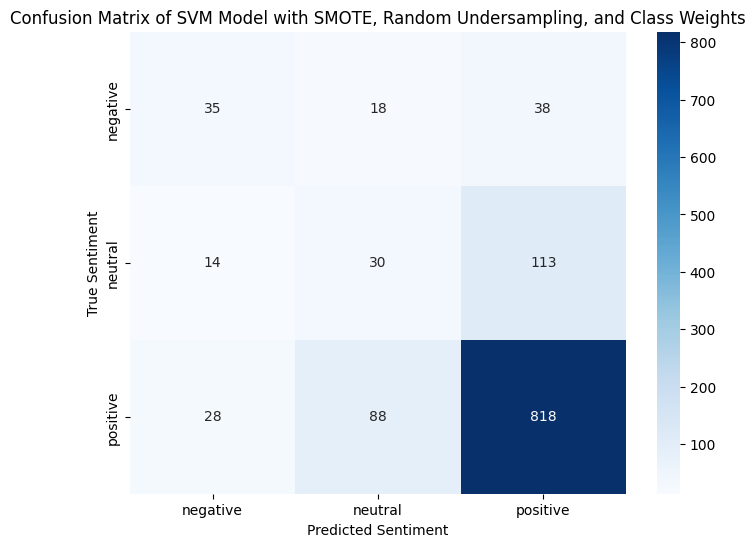

In [24]:
# Visualize the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted Sentiment')
plt.ylabel('True Sentiment')
plt.title('Confusion Matrix of SVM Model with SMOTE, Random Undersampling, and Class Weights')
plt.show()

In [25]:
# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

Precision: 0.7313
Recall: 0.7470
F1-Score: 0.7386


In [27]:
y_pred

array(['neutral', 'neutral', 'positive', ..., 'neutral', 'positive',
       'positive'], dtype=object)

In [28]:
y_test

3489    negative
4909    positive
1425    positive
4743     neutral
439     positive
          ...   
5333    positive
4310    positive
653     positive
429      neutral
1773    positive
Name: sentiment, Length: 1182, dtype: object

In [30]:

predictions_df = pd.DataFrame({
    'review_text': review_df.loc[y_test.index, 'review'],  # Assuming X_test is a subset with a specific index
    'actual_sentiment': y_test,  # The actual sentiment labels
    'predicted_sentiment': y_pred  # The predicted sentiment labels
})

predictions_df.head(10)


,review_text,actual_sentiment,predicted_sentiment
3489,While I should probably come back at a better ...,negative,neutral
4909,Nice place Have Food Court KFC Lawson Bic C Se...,positive,neutral
1425,Since I was born and grew up in Ceylon (Sri La...,positive,positive
4743,This shrine is located in front of Central\nWo...,neutral,positive
439,Wat Suan Dok is just east of the Old City on S...,positive,positive
5490,"Every old Thai city has its City Lake, Khon Ka...",positive,positive
1319,"On every Saturday and Sunday from 17:00-22:00,...",positive,positive
1330,This was a fantastic spot to not only stretch ...,positive,positive
4091,"Took daughter, she seemed to have a fun time ...",positive,positive
296,Cute elephant and nice people with lovely food...,positive,positive


In [31]:
predictions_df.to_csv("../prediction/SVN_Prediction.csv")